## Asana: Data Science Internship Take Home | Summer 2024 by Ophelia Sin

The goal of this take home is to 
1. Calculate the adoption rate and 
2. Identify variables that predict user adoption. 

First, the data was cleaned and preprocessed. Second, I calculated the adoption rate based on the `user_engagement` table. Third and lastly, I created a Random Forest Model to identify the largest predictors of user adoption.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
users = pd.read_csv("https://s3.amazonaws.com/asana-data-interview/takehome_users-intern.csv")
user_engagement = pd.read_csv("https://s3.amazonaws.com/asana-data-interview/takehome_user_engagement-intern.csv")

### Data Cleaning

In [3]:
users = users.rename(columns={'object_id': 'user_id'}) #rename object_id to user_id for future join
users['email'] = users['email'].str.lower() #converting all email to lowercase

users['creation_time'] = pd.to_datetime(users['creation_time'], unit = 'ns')
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')

#changing type to category
users['creation_source'] = users['creation_source'].astype('category') 
users['org_id'] = users['org_id'].astype('category')

#changing type to boolean
users['opted_in_to_mailing_list'] = users['opted_in_to_mailing_list'].astype(bool)
users['enabled_for_marketing_drip'] = users['enabled_for_marketing_drip'].astype(bool)

#filling NaNs as 0, since the minimum value in the invited_by_user_id column is 3.0
users['invited_by_user_id'].fillna(0, inplace=True)
users['invited_by_user_id'] = users['invited_by_user_id'].astype(int)

I removed the `visited` column in `user_engagement` since it only consists of 1s. 

In [4]:
user_engagement = user_engagement.drop(["visited"], axis = 1)

I'm going to use `user_engagement` to calculate the adoption rate. 
I created a new dataframe to store `user_id` as the key and the list of `timestamps` as the value. 

In [5]:
list_of_users = user_engagement.user_id.unique().tolist() #convert user_id column to list
hMap = {i: [] for i in list_of_users} 
for index,row in user_engagement.iterrows(): 
    hMap[row['user_id']].append(row['time_stamp'])

user_engagement_revised = pd.DataFrame(list(hMap.items()), columns=['user_id', 'login_dates']) #convert hashmap to dataframe

# Convert each string in the list to a datetime object using apply and a lambda function
user_engagement_revised['login_dates'] = user_engagement_revised['login_dates'].apply(lambda x: [pd.to_datetime(date_str) for date_str in x])

### 1) Calculating Adoption Rate

**"Adopted user"**: a user who has logged into the product on three separate days in at least one seven-day period

To check whether a user is adopted, I wrote a function to verify if a subset of three consecutive dates are within a 7-day period. 

In [6]:
from datetime import timedelta

def has_adopted(row):
    sorted_dates = sorted(row['login_dates'])
    
    # Initialize variables to track consecutive logins and the start date of the current window
    current_start_date = None
    consecutive_logins = 0
    
    k = 3 #size of sliding window 
    seven_days = timedelta(days=7) # Define the 7-day time window
    list_of_dates = []

    for i in range(len(sorted_dates) - k + 1):
        if current_start_date is None:
            current_start_date = sorted_dates[i]
            consecutive_logins = 1
            list_of_dates.append(current_start_date)
        elif sorted_dates[i] - current_start_date <= seven_days:
            consecutive_logins += 1
            list_of_dates.append(sorted_dates[i])
        else:
            current_start_date = sorted_dates[i]
            list_of_dates = [current_start_date]
            consecutive_logins = 1
        
        if consecutive_logins >= 3:
            return True

    return False

In [7]:
user_engagement_revised['has_adopted'] = user_engagement_revised.apply(has_adopted, axis=1) #apply the has_adopted function to each row

In order to calculate the adoption rate, I compared the number of users that are adopted vs the total number of users. To do so, I joined `users` and `user_engagement_revised`. 

I also dropped all users that have not logged in since they created their account to prevent them from being considered when calculating the adoption rate.

In [8]:
merged_df = users.merge(user_engagement_revised, on = 'user_id', how = 'outer')

#replace all NaNs in the has_adopted column with False
merged_df['has_adopted'].fillna(False, inplace=True)

#remove users that have not logged in after signup
merged_df.dropna(subset=['last_session_creation_time'], inplace=True)

In [9]:
#Adoption rate formula = (has_adopted == False)/ total_users
total_adoption_rate = (merged_df['has_adopted'].sum()) / len(merged_df) 
print("The total adoption rate is {:.2f}.".format(total_adoption_rate))

The total adoption rate is 0.17.


To better understand what types of users are adopting Asana, I looked at the adoption rates of users by `creation_source`, `opted_in_to_mailing_list` and `enabled_for_marketing_drip`.

By looking at adoption rate by creation source, I found that (1) users that were invited to an organization as a guest and (2) users that invited to join another user's personal workspace had the highest adoption rates. A higher adoption rate for organization guests may be the result of an intensive involvement by external consultants during a short period of time. 

/var/folders/y3/1ld116210xs2ztcb6hbqjrhm0000gn/T/ipykernel_9745/3078669519.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adoption_rate = merged_df.groupby('creation_source')['has_adopted'].mean()


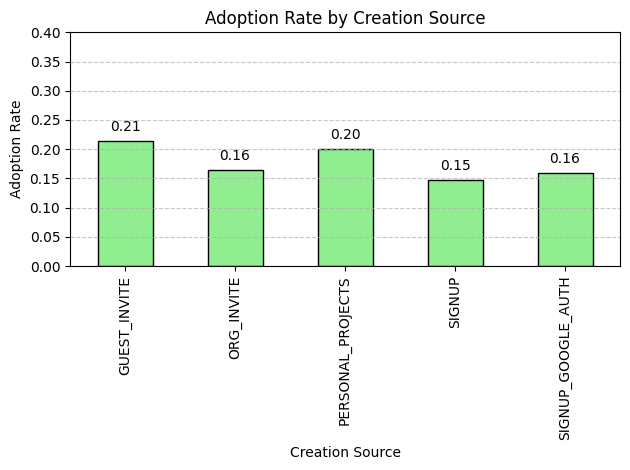

In [10]:
# Calculate the adoption rate by 'creation_source'
adoption_rate = merged_df.groupby('creation_source')['has_adopted'].mean()

# Plot the adoption rate
ax = adoption_rate.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title('Adoption Rate by Creation Source')
plt.xlabel('Creation Source')
plt.ylabel('Adoption Rate')
plt.ylim(0, 0.4)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for p in ax.patches:
    ax.annotate(f"{p.get_height():.2f}", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

plt.tight_layout()
plt.show()

If we look at the adoption rate by `opted_in_to_mailing_list` and `enabled_for_marketing_drip`, we cannot observe a statistically significant difference between those who have signed up for mailing list or marketing drip and those who don't.

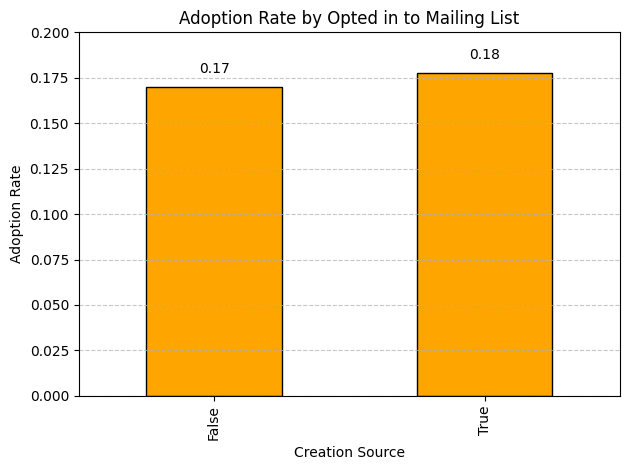

In [11]:
# Calculate the adoption rate by 'creation_source'
opted_in_to_mailing_list_adoption_rate = merged_df.groupby('opted_in_to_mailing_list')['has_adopted'].mean()

ax1 = opted_in_to_mailing_list_adoption_rate.plot(kind='bar', color='orange', edgecolor='black')
plt.title('Adoption Rate by Opted in to Mailing List')
plt.xlabel('Creation Source')
plt.ylabel('Adoption Rate')
plt.ylim(0, 0.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for p in ax1.patches:
    ax1.annotate(f"{p.get_height():.2f}", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', 
                xytext=(0, 10), 
                textcoords='offset points')

plt.tight_layout()
plt.show()

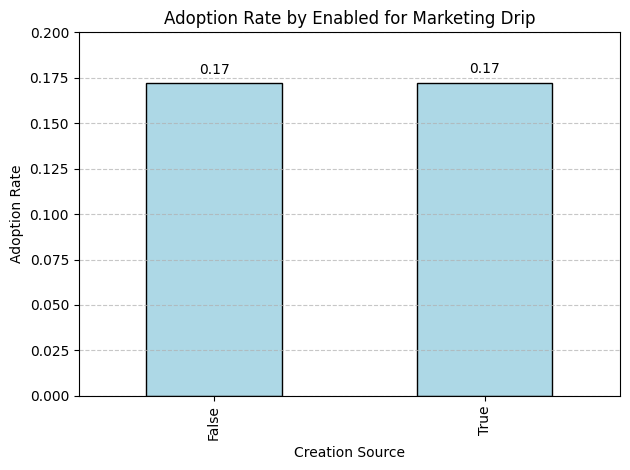

In [12]:
# Calculate the adoption rate by 'creation_source'
enabled_for_marketing_drip_adoption_rate = merged_df.groupby('enabled_for_marketing_drip')['has_adopted'].mean()

ax2 = enabled_for_marketing_drip_adoption_rate.plot(kind='bar', color='lightblue', edgecolor='black')
plt.title('Adoption Rate by Enabled for Marketing Drip')
plt.xlabel('Creation Source')
plt.ylabel('Adoption Rate')
plt.ylim(0, 0.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for p in ax2.patches:
    ax2.annotate(f"{p.get_height():.2f}", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

plt.tight_layout()
plt.show()

### 3) What Factors Predict User Adoption?

I choose to use the Random Forest model to identify which factors predict user adoption for 3 main reasons:
1. It tells us which feature have the most impact of the model's prediction.
2. It doesn't assume a linear relationship between features and user adoption.
3. It is less prone to overfitting. 

A new column `org_count` is joined to `merged_df` as a numerical variable for each observation to indicate the number of times the respective `org_id` has occured in the dataset.

In [13]:
org_id_counts = merged_df['org_id'].value_counts().to_frame()
org_id_counts.rename(columns = {'count': 'org_count'}, inplace= True)

In [14]:
merged_df = merged_df.merge(org_id_counts, how = 'left', on = 'org_id')

In [15]:
#separate date and time in creation_time
merged_df['last_session_creation_time_day_of_week'] = merged_df['last_session_creation_time'].dt.dayofweek
merged_df['last_session_creation_time_hour'] = merged_df['last_session_creation_time'].dt.hour
merged_df['last_session_combined_date'] = (merged_df['last_session_creation_time'].dt.year - 2000) * 12 + merged_df['last_session_creation_time'].dt.month


#separate date time in last_session_creation_time 
merged_df['creation_date_day_of_week'] = merged_df['creation_time'].dt.dayofweek
merged_df['creation_date_hour'] = merged_df['creation_time'].dt.hour
merged_df['creation_date_combined_date'] = (merged_df['creation_time'].dt.year - 2000) * 12 +merged_df['creation_time'].dt.month


In [16]:
#I looked at variables that I intuitively thought would be influencing the adopted rate. 
#convert categorical features to binary features
encoded_df = pd.get_dummies(merged_df, columns=['creation_source'])

xvars are selected based on multiple iterations of testing. The selected variables are significant predictors.

In [17]:

xvars = [
         'creation_date_day_of_week', 
         'opted_in_to_mailing_list', 'enabled_for_marketing_drip',	
          'creation_date_hour', 
          'org_count',
          'last_session_creation_time_day_of_week', 
          'last_session_creation_time_hour', 
          'last_session_combined_date',
          'creation_date_combined_date',
        ]
yvar = 'has_adopted'

In [18]:
from sklearn.model_selection import train_test_split

df_to_fit = encoded_df[xvars+[yvar]]

X_train, X_test, y_train, y_test = train_test_split(
    df_to_fit[xvars], df_to_fit[yvar], test_size = 0.25, random_state = 10)

Keeping all other hyperparameters as default due to a relatively small sample size, I specified the number of trees used in the Random Forest. Changing the n_estimators variable between 10 to 100 impacts the accuracy score by 0.04. 

In [19]:
from sklearn.ensemble import RandomForestClassifier

model1 = RandomForestClassifier(n_estimators = 10, random_state = 10)
model1.fit(X_train, y_train)
print("Model 1: ", model1.score(X_train, y_train))

model2 = RandomForestClassifier(n_estimators = 30, random_state = 10)
model2.fit(X_train, y_train)
print("Model 2: ", model2.score(X_train, y_train))

Model 1:  0.9953150974761976
Model 2:  0.9996977482242708


The top features that predict adoption are `last_session_combined_date` and `creation_date_combined_date`. Other date-time related variables are also influential to the predictive model. Suprisingly, whether a user has signed up for regular marketing updates/ emails doesn't help predict the adoption rate.

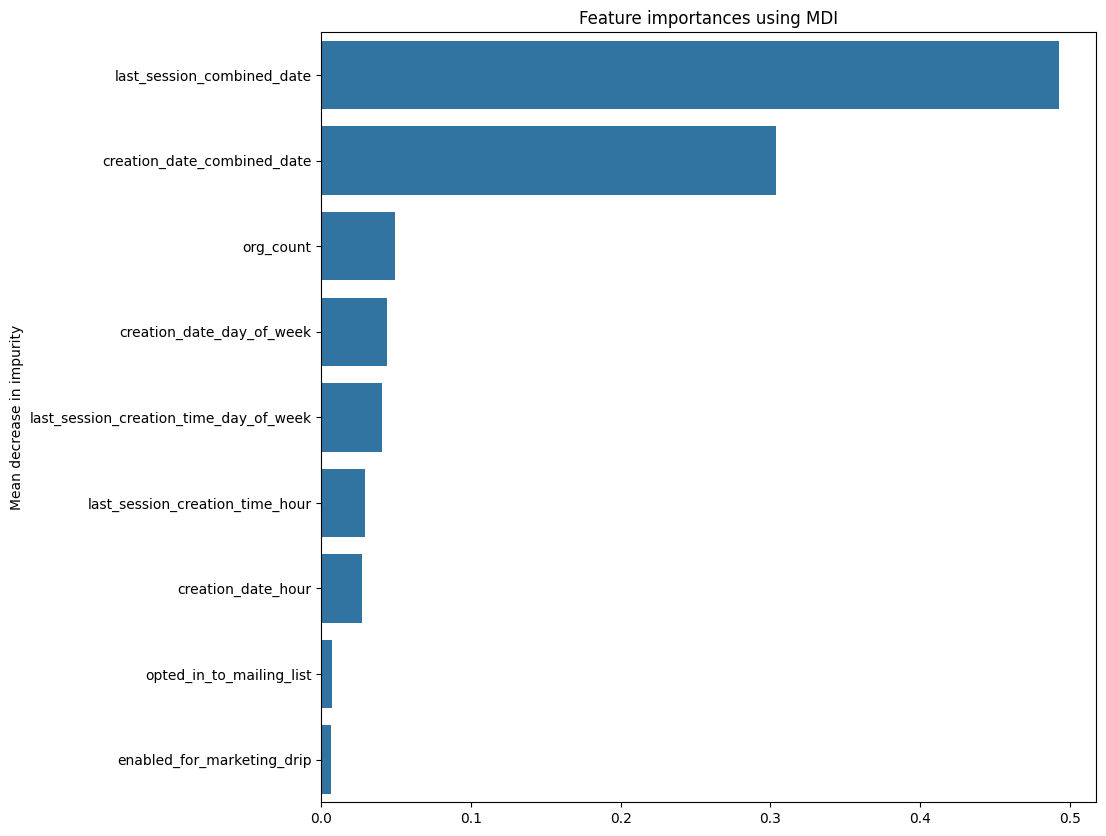

In [20]:
importances = model1.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)
std = np.std([tree.feature_importances_ for tree in model1.estimators_], axis=0)
forest_importances.sort_values(inplace=True, ascending=False)

fig, ax = plt.subplots(figsize = (10,10))
sns.barplot(x=forest_importances.values, y=forest_importances.index, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
plt.show()

The significance of the combined_date variables in predicting 'adopted users' suggests that usage rates fluctuate during specific times of the year, potentially due to seasonal influences or external events globally. Moreover, as the third strongest influencer, the variable `org_count` may indicate that users from the same organization may have similar adoption behaviors. 

### Recommendations

1. Focus on the time periods of which users are using Asana at more frequently. Delve into the specific use cases/ projects these adopted users are creating.
2. Monitor the adopted users' pattern that indicates when and why adopted users log in. Leverage this data to encourage more frequent logins in non-adopted users. 
3. Since marketing drip and the mailing list aren't great predictors of whether a user is adopted, the current email marketing strategy should be reevaluated and revamped as an adopted user conversion tool.